## for GPU-accelerated ELM, install `scikit-cuda` package from Pip

In [ ]:
# !pip install numpy==1.21 scikit-cuda hpelm
!pip install numpy==1.21 scikhpelm

In [23]:
import hpelm

In [24]:
import numpy as np

In [25]:
from sklearn.datasets import make_moons, make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [26]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = [10, 8]

## Prepare some data

In [27]:
X, Y = make_moons(n_samples=2000000, noise=0.3)
Xt, Xs, Yt, Ys = train_test_split(X, Y, test_size=0.3)
subs = 1000  # subsampling for plots
L = 100  # number of non-linear neurons

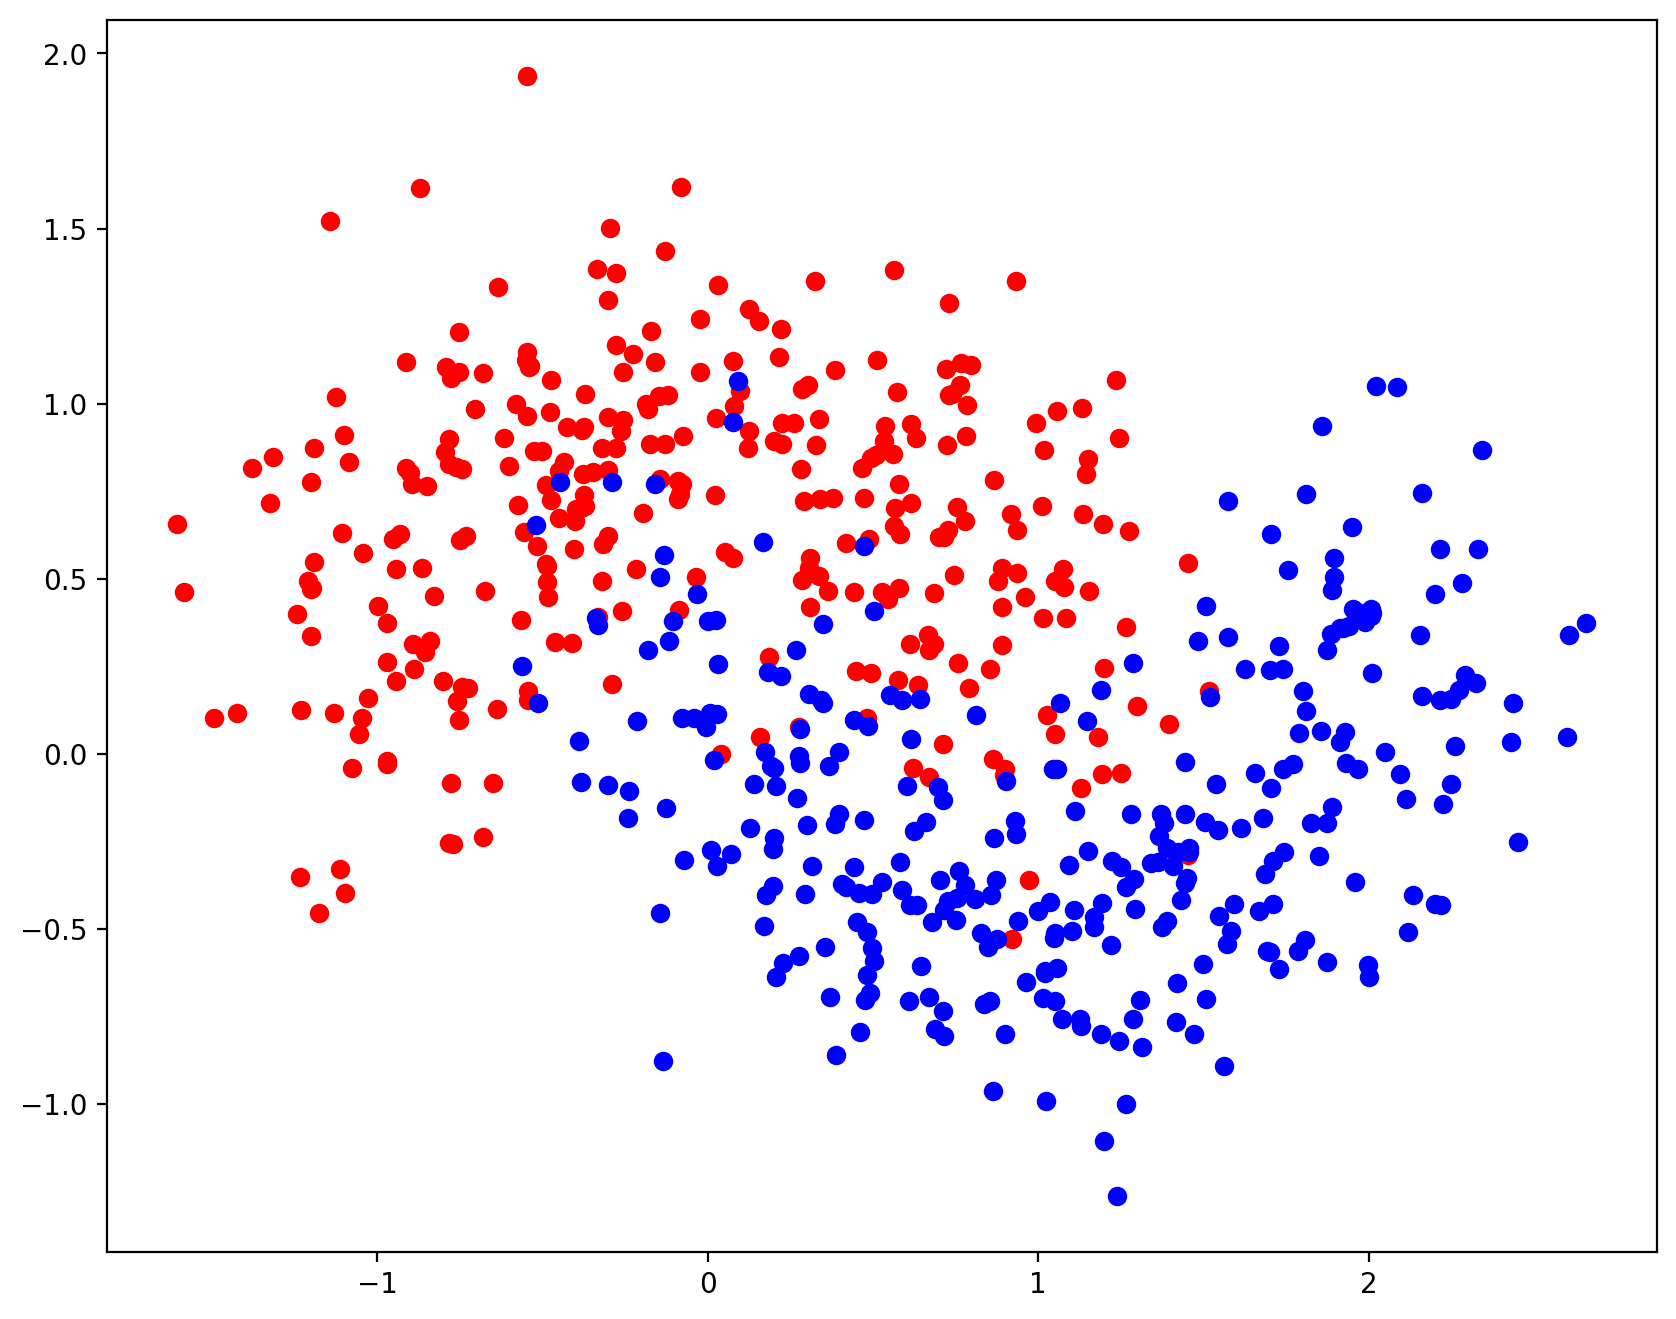

In [28]:
plt.scatter(Xs[Ys==0, 0][::subs], Xs[Ys==0, 1][::subs], c="r")
plt.scatter(Xs[Ys==1, 0][::subs], Xs[Ys==1, 1][::subs], c="b")
plt.show()

In [29]:
rfc = RandomForestClassifier(n_estimators=8, n_jobs=-1)
%time rfc.fit(Xt, Yt)
Yh = rfc.predict(Xs)

CPU times: user 28.5 s, sys: 362 ms, total: 28.8 s
Wall time: 5.01 s


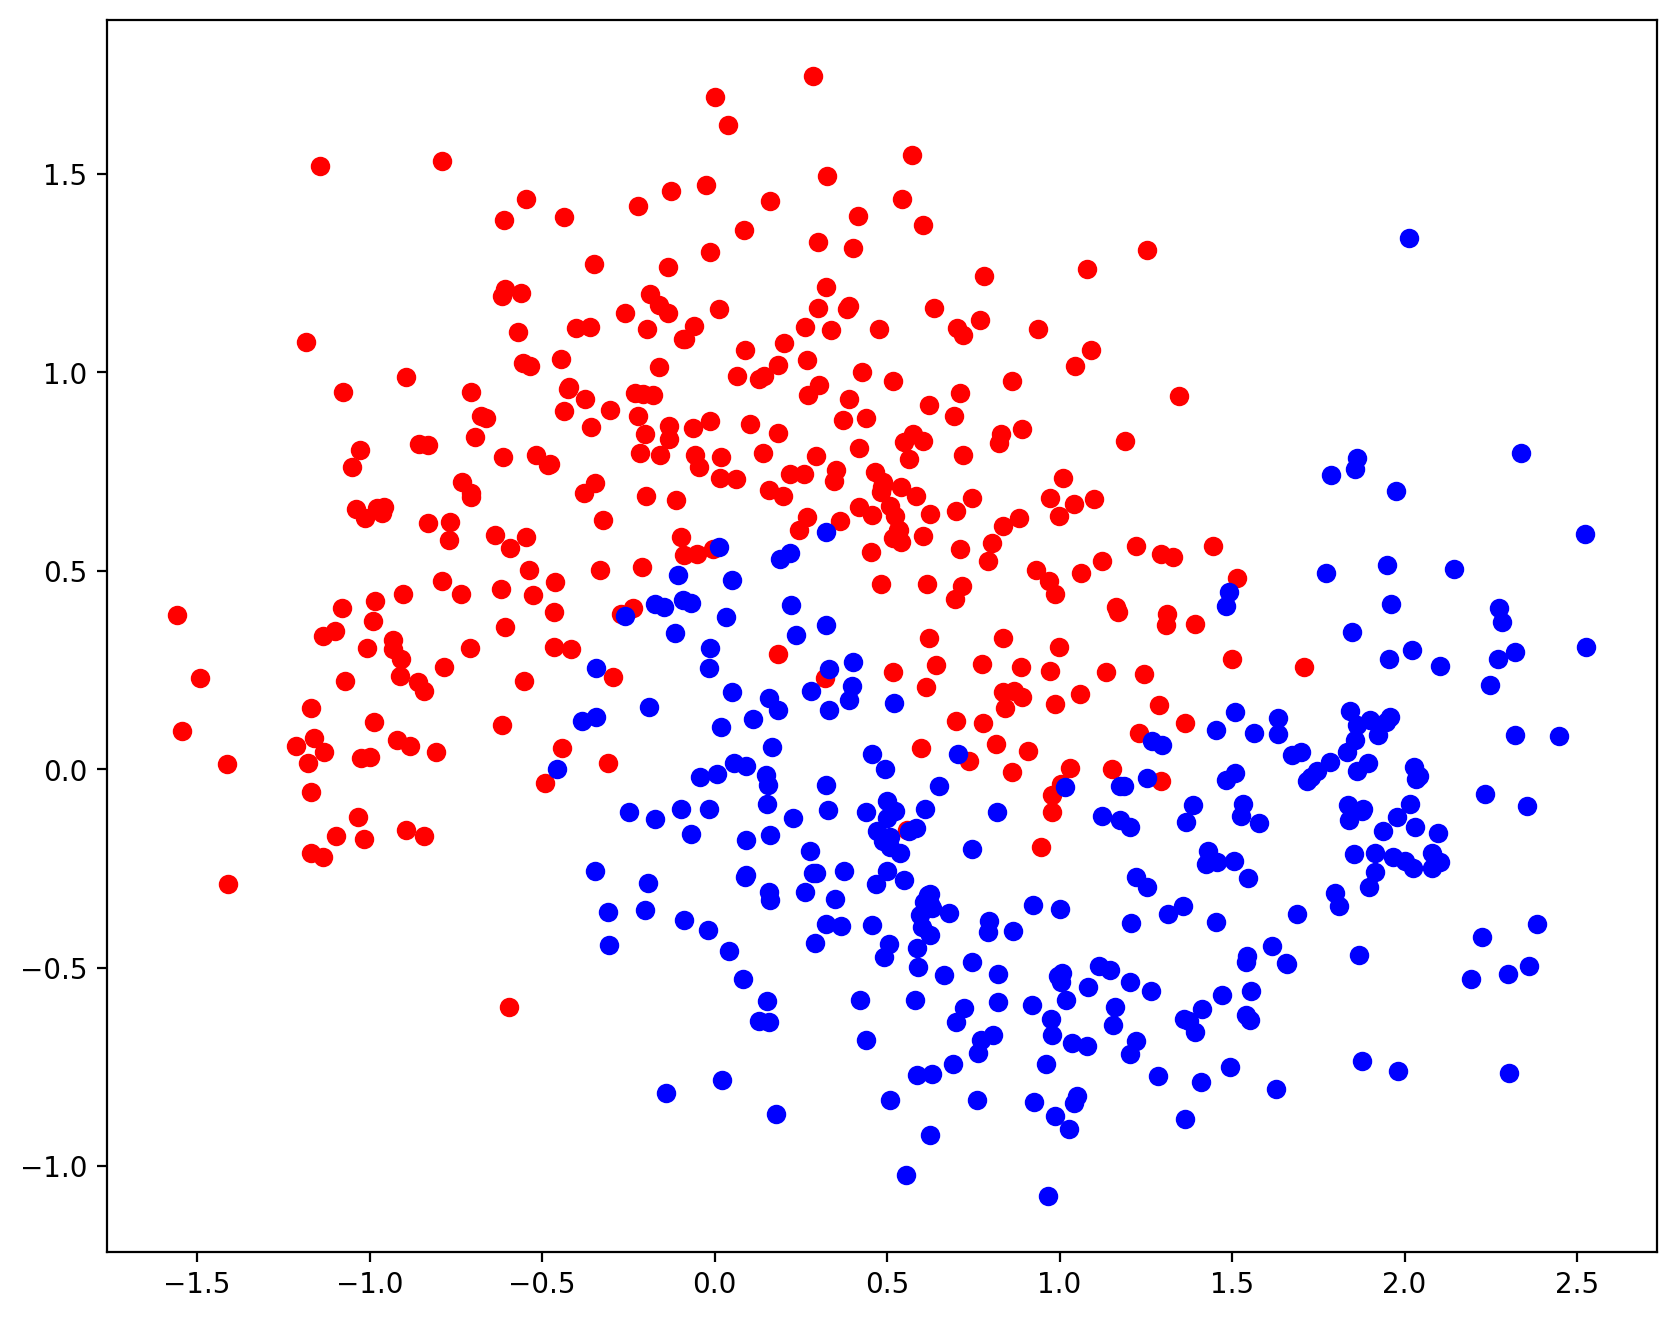

In [30]:
plt.scatter(Xs[Yh==0, 0][::subs], Xs[Yh==0, 1][::subs], c="r")
plt.scatter(Xs[Yh==1, 0][::subs], Xs[Yh==1, 1][::subs], c="b")
plt.show()

## Run HPELM

In [31]:
elm = hpelm.HPELM(2, 1, precision='double', norm=1)

In [32]:
elm.add_neurons(2, 'lin')
elm.add_neurons(L, 'tanh')

In [33]:
%time elm.train(Xt, Yt)

CPU times: user 1.01 s, sys: 35.5 ms, total: 1.04 s
Wall time: 1.05 s


In [34]:
Yh = elm.predict(Xs)

In [35]:
Yh = np.array(Yh[:,0] > 0.5, dtype=int)

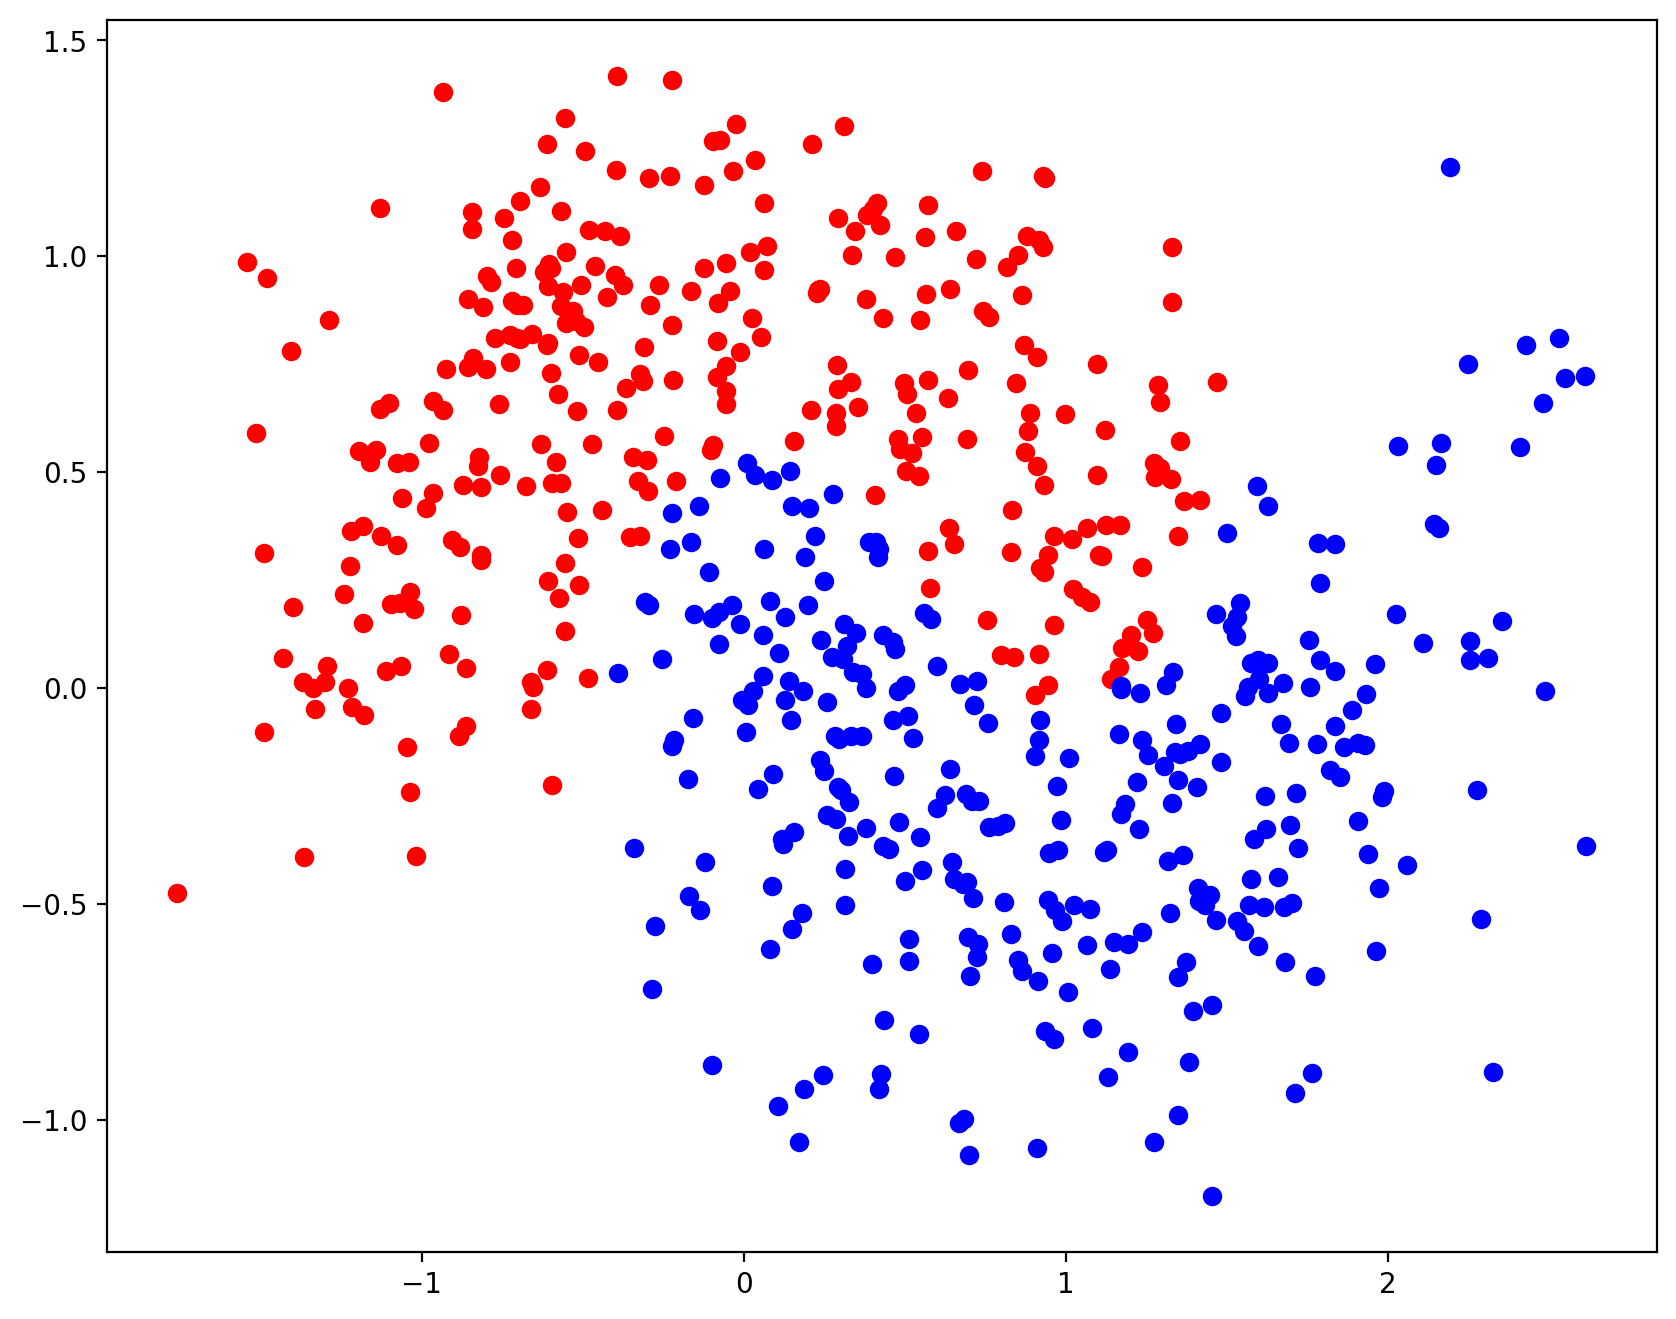

In [36]:
plt.scatter(Xs[Yh==0, 0][::subs], Xs[Yh==0, 1][::subs], c="r")
plt.scatter(Xs[Yh==1, 0][::subs], Xs[Yh==1, 1][::subs], c="b")
plt.show()

## Run HPELM+GPU

In [37]:
import os

In [44]:
# elm2 = hpelm.HPELM(2, 1, precision='single', accelerator="GPU", norm=1)
elm2 = hpelm.HPELM(2, 1, precision='single', norm=1)

In [45]:
elm2.add_neurons(2, 'lin')
elm2.add_neurons(L, 'tanh')

In [46]:
%time elm2.train(Xt, Yt)

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
CPU times: user 894 ms, sys: 36.5 ms, total: 931 ms
Wall time: 944 ms


In [47]:
Yh = elm2.predict(Xs)

In [48]:
Yh = np.array(Yh[:,0] > 0.5, dtype=np.int)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
plt.scatter(Xs[Yh==0, 0][::subs], Xs[Yh==0, 1][::subs], c="r")
plt.scatter(Xs[Yh==1, 0][::subs], Xs[Yh==1, 1][::subs], c="b")
plt.show()

## Dummy task with very large data

In [23]:
X_big = np.random.randn(10000000, 200)  # 10 million samples

In [43]:
# outputs are sums of first 10 and second 10 input values
Y_big = np.stack((X_big[:, :10].sum(1), X_big[:, 10:20].sum(1))).T
Y_big.shape

(10000000, 2)

In [44]:
elm_cpu = hpelm.HPELM(200, 2)
elm_gpu = hpelm.HPELM(200, 2, precision="single", accelerator="GPU")

Using CUDA GPU acceleration with Scikit-CUDA


In [45]:
elm_cpu.add_neurons(200, 'lin')
elm_cpu.add_neurons(1000, 'tanh')

elm_gpu.add_neurons(200, 'lin')
elm_gpu.add_neurons(1000, 'tanh')

In [46]:
%%time
elm_cpu.train(X_big, Y_big)

processing batch 371/10000, eta 0:02:10
processing batch 735/10000, eta 0:02:06
processing batch 1101/10000, eta 0:02:01
processing batch 1467/10000, eta 0:01:56
processing batch 1841/10000, eta 0:01:50
processing batch 2214/10000, eta 0:01:45
processing batch 2596/10000, eta 0:01:39
processing batch 2976/10000, eta 0:01:34
processing batch 3356/10000, eta 0:01:29
processing batch 3728/10000, eta 0:01:24
processing batch 4110/10000, eta 0:01:18
processing batch 4490/10000, eta 0:01:13
processing batch 4871/10000, eta 0:01:08
processing batch 5253/10000, eta 0:01:03
processing batch 5633/10000, eta 0:00:58
processing batch 6007/10000, eta 0:00:53
processing batch 6388/10000, eta 0:00:48
processing batch 6767/10000, eta 0:00:43
processing batch 7147/10000, eta 0:00:37
processing batch 7531/10000, eta 0:00:32
processing batch 7909/10000, eta 0:00:27
processing batch 8282/10000, eta 0:00:22
processing batch 8663/10000, eta 0:00:17
processing batch 9045/10000, eta 0:00:12
processing batch 9

In [47]:
%%time
elm_gpu.train(X_big, Y_big)

processing batch 1534/10000, eta 0:00:27
processing batch 3131/10000, eta 0:00:21
processing batch 4726/10000, eta 0:00:16
processing batch 6297/10000, eta 0:00:11
processing batch 7879/10000, eta 0:00:06
processing batch 9453/10000, eta 0:00:01
CPU times: user 21 s, sys: 11.6 s, total: 32.6 s
Wall time: 31.8 s


plots checking that output weights correctly correspond 
to sum of first 10 inputs and the next 10 inputs

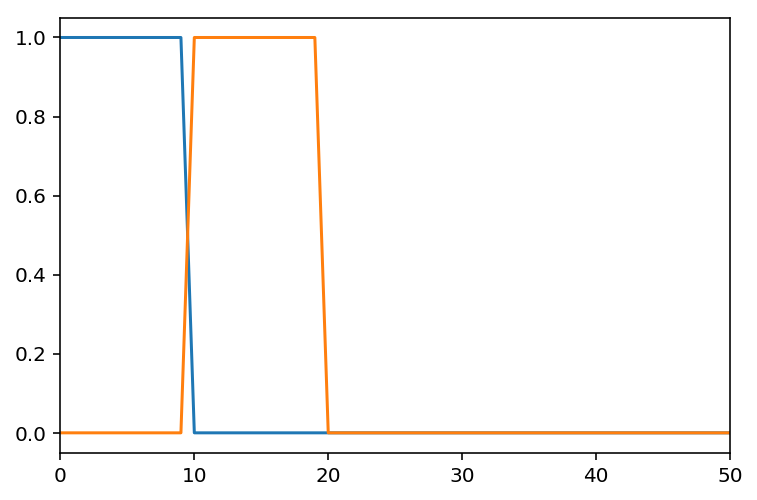

In [74]:
B_cpu = elm_cpu.nnet.get_B()
plt.plot(range(1200), B_cpu[:,0])
plt.plot(range(1200), B_cpu[:,1])
plt.xlim([0, 50])
plt.show()

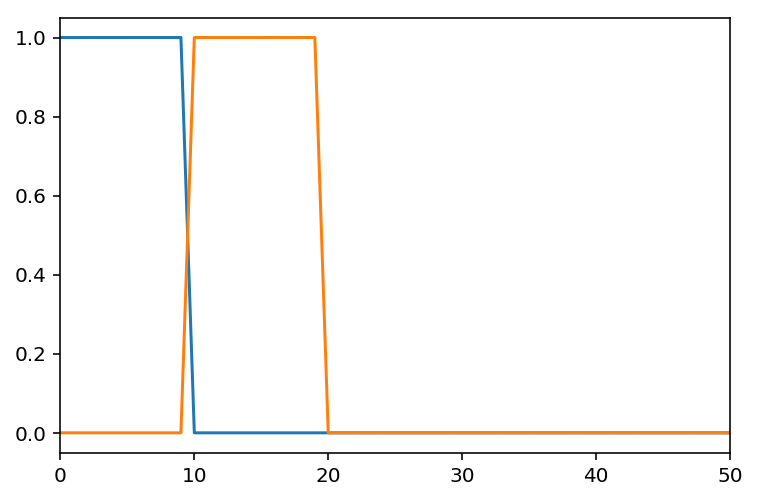

In [75]:
B_gpu = elm_gpu.nnet.get_B()  # this corectly downloads weights from GPU back to main memory
plt.plot(range(1200), B_gpu[:,0])
plt.plot(range(1200), B_gpu[:,1])
plt.xlim([0, 50])
plt.show()